In [1]:
!unzip train_val_test.zip

Archive:  train_val_test.zip
 extracting: test.zip                
 extracting: train.zip               
 extracting: val.zip                 


In [2]:
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/sad/Training_67094111.jpg  
  inflating: test/sad/sad1051.jpg    
  inflating: test/sad/sad1900.jpg    
  inflating: test/sad/Training_97360221.jpg  
  inflating: test/sad/Training_26809713.jpg  
  inflating: test/sad/sad864.jpg     
  inflating: test/sad/Training_22358838.jpg  
  inflating: test/sad/sad2769.jpg    
  inflating: test/sad/sad2779.jpg    
  inflating: test/sad/Training_60572916.jpg  
  inflating: test/sad/Training_12396877.jpg  
  inflating: test/sad/Training_43234355.jpg  
  inflating: test/sad/sad2650.jpg    
  inflating: test/sad/Training_54757164.jpg  
  inflating: test/sad/Training_33455689.jpg  
  inflating: test/sad/Training_19952390.jpg  
  inflating: test/sad/sad1841.jpg    
  inflating: test/sad/Training_70091553.jpg  
  inflating: test/sad/sad64.jpg      
  inflating: test/sad/PublicTest_30717850.jpg  
  inflating: test/sad/Training_65586139.jpg  
  inflating: test/sad/Training_27359156.jpg  

In [3]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [4]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import image_dataset_from_directory

In [5]:
test_dir = os.path.join("test")
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='rgb',
    batch_size=32)

Found 6293 files belonging to 7 classes.


In [6]:
# retrieving VGG19
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(48, 48, 3)
)

80134624/80134624 [==============================] - 1s 0us/step


In [7]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 757ms/step


In [8]:
print(test_features.shape)
print(test_labels.shape)

(6293, 1, 1, 512)
(6293, 7)


In [23]:
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>


In [52]:
fine_tuned_model = keras.models.load_model("fine_tuning_efficientnetb5.h5")

def get_predictions(model, dataset):
    all_predictions = []
    all_labels = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_predictions.append(predictions)
        all_labels.append(labels)
    return np.concatenate(all_predictions), np.concatenate(all_labels)

fine_tuned_predictions, fine_tuned_labels = get_predictions(fine_tuned_model, test_dataset)

1/1 [==============================] - 6s 6s/step


In [53]:
num_classes = test_labels.shape[1]
print(f"Number of classes: {num_classes}")


Number of classes: 7


In [54]:
predicted_classes_ft = np.argmax(fine_tuned_predictions, axis=1)
true_classes_ft = np.argmax(fine_tuned_labels, axis=1)

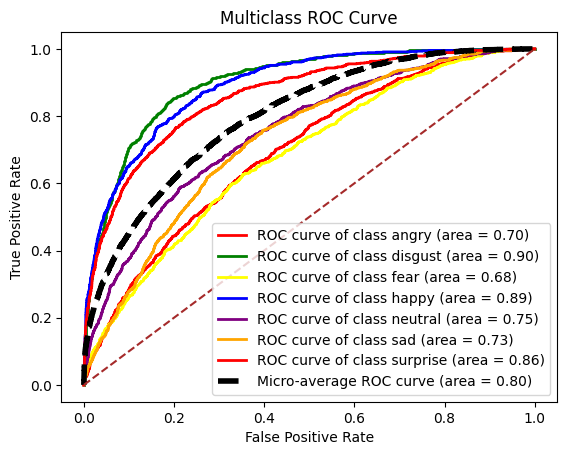

In [55]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

test_labels_bin_ft = label_binarize(true_classes_ft, classes=range(n_classes))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin_ft[:, i], fine_tuned_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin_ft.ravel(), fine_tuned_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()

colors = cycle(['red', 'green', 'yellow', 'blue', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='black', linestyle='--', linewidth=4)

plt.plot([0, 1], [0, 1], color='brown', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [56]:
from sklearn.metrics import classification_report

report = classification_report(true_classes_ft, predicted_classes_ft, target_names=classes)
print(report)

              precision    recall  f1-score   support

       angry       0.31      0.21      0.25       899
     disgust       0.51      0.72      0.59       899
        fear       0.36      0.12      0.18       899
       happy       0.54      0.62      0.58       899
     neutral       0.35      0.43      0.38       899
         sad       0.30      0.24      0.27       899
    surprise       0.47      0.64      0.54       899

    accuracy                           0.43      6293
   macro avg       0.40      0.43      0.40      6293
weighted avg       0.40      0.43      0.40      6293



In [57]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes_ft, predicted_classes_ft)
print(f"Accuracy: {accuracy}")


Accuracy: 0.42634673446686794


In [58]:
y_pred = np.argmax(predictions, axis=1)
y_label = np.argmax(test_labels, axis=1)

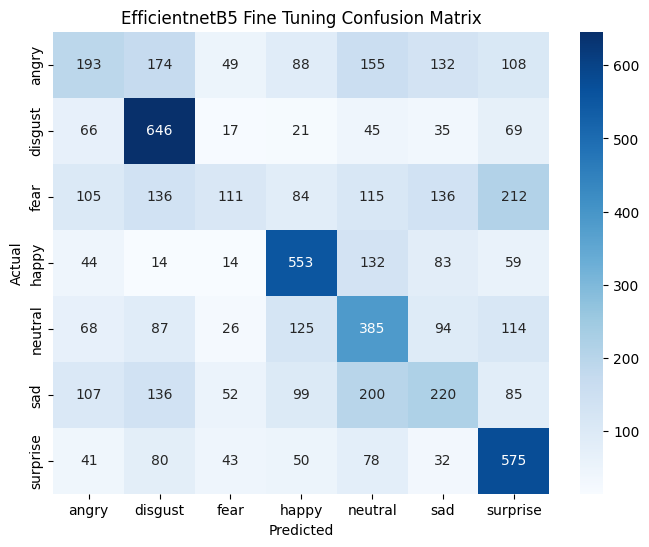

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes_ft, predicted_classes_ft)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('EfficientnetB5 Fine Tuning Confusion Matrix')
plt.show()
